## Phosphatidylcholine (34:0) 

In [1]:
import sys,os,glob

In [2]:
sys.path.append('/home/simon/git/pymzm')
sys.path.append('/home/simon/git/mass-spec-utils')

In [18]:
condition = 1
ion_mode = 'Pos'

In [19]:
mzml_folder = '/home/simon/data/lipid_files/lipid_files/Condition_{}/{}/'.format(condition,ion_mode)
pp_folder = os.path.join(mzml_folder,'picked_peaks')

In [20]:
mzml_file_list = glob.glob(os.path.join(mzml_folder,'*.mzML'))
mzml_pp = []
for m in mzml_file_list:
    final_part = m.split(os.sep)[-1]
    pp_name = final_part.split('.')[0] + '_box.csv'
    mzml_pp.append((m,os.path.join(pp_folder,pp_name)))
    
for m,p in mzml_pp:
    print(m,p)

/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/0_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/0_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/48_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/48_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/96_pp_d20_.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/96_pp_d20__box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/24_pp_s3_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/24_pp_s3_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/72_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/72_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/8_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/8_pp_d2

In [21]:
from ms2_matching import load_picked_boxes,MZMLFile

In [22]:
all_boxes = {}
for m,p in mzml_pp:
    all_boxes[p] = load_picked_boxes(p)

In [23]:
all_mzml_file_obj = {}
for m,p in mzml_pp:
    all_mzml_file_obj[p] = MZMLFile(m)

Loaded 1968 scans
Loaded 1968 scans
Loaded 1967 scans
Loaded 1968 scans
Loaded 1968 scans
Loaded 1968 scans


Add chromatograms back to the peaks

In [24]:
from chromatograms import add_chromatograms_to_boxes
for p in all_boxes:
    add_chromatograms_to_boxes(all_boxes[p],all_mzml_file_obj[p])
    

In [25]:
from chromatograms import cluster_box_chromatograms
all_groups = {}
for p in all_boxes:
    all_groups[p],_ = cluster_box_chromatograms(all_boxes[p],threshold = 0.8,max_mz_diff = 10)

In [26]:
def find_boxes(boxes,mz,rt_in_seconds,mz_tol = 0.01,rt_tol = 10):
    sub_boxes = list(filter(lambda x: abs(x.mz - mz) <= mz_tol and 
                            abs(x.rt_in_seconds - rt_in_seconds) <= rt_tol,boxes))
    return sub_boxes

In [33]:
from molmass import Formula
f = Formula('C42H84NO8P')
from adduct_rules import AdductTransformer
at = AdductTransformer()
print("Mono: ",f.isotope.mass)
if ion_mode == 'Pos':
    phosp_mz = at.mass2ion(f.isotope.mass,'[M+H]+')
else:
    phosp_mz = at.mass2ion(f.isotope.mass,'[M-H]-')
phosp_mz = 760.584
phosp_rt = 627
print(phosp_mz,phosp_rt)
f.spectrum()

Mono:  761.59345566673
760.584 627


{761: [761.593455666729, 0.6159481852928886],
 762: [762.5968270077318, 0.2898790147915327],
 763: [763.5998704062844, 0.076820000158829],
 764: [764.6027667510053, 0.014758948620655106],
 765: [765.6055781348612, 0.0022652756501092665],
 766: [766.608333268315, 0.00029231087490953235],
 767: [767.611049872755, 3.2710779144349316e-05],
 768: [768.6137401012427, 3.2398181913962025e-06],
 769: [769.616465431479, 2.8349908701219827e-07],
 770: [770.6195142186359, 1.575868520568111e-08],
 771: [771.6228197970403, 1.4096928955712096e-10]}

In [34]:
all_phosp = {}
for p in all_boxes:
    l = find_boxes(all_boxes[p],phosp_mz,phosp_rt,rt_tol = 10)
    assert len(l) == 1,print(len(l))
    l = l[0]
    # find the group
    for g in all_groups[p]:
        if l in g:
            break
    all_phosp[p] = (l,g)

In [35]:
import pylab as plt
%matplotlib inline

In [36]:
# order files by time
ordered_files = list(all_boxes.keys())
ordered_files.sort(key = lambda x: int(x.split(os.sep)[-1].split('_')[0]))


4
4
4
6
5
6


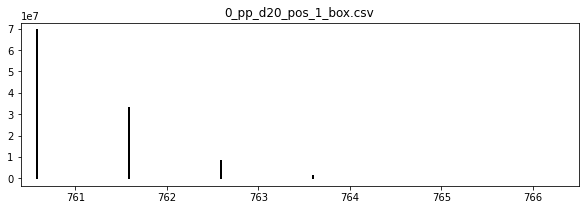

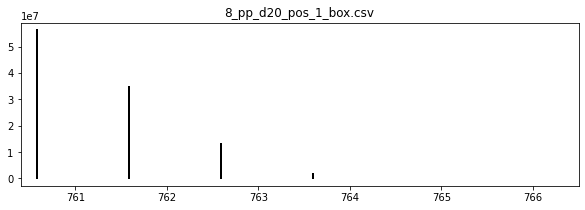

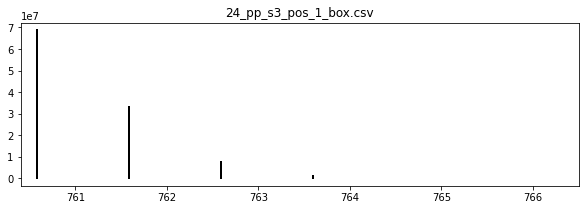

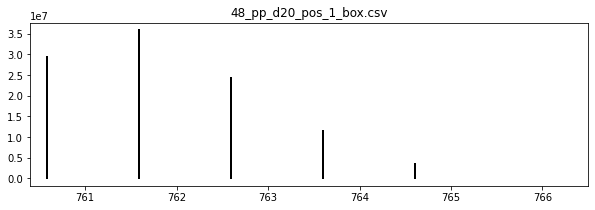

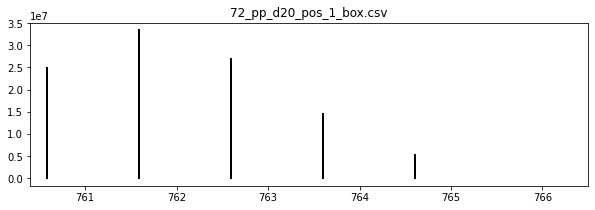

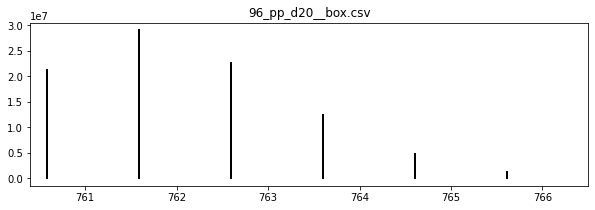

In [38]:
for f in ordered_files:
    plt.figure(figsize=(10,3))
    b,g = all_phosp[f]
    print(len(g))
    for box in g:
        plt.plot([box.mz,box.mz],[0,box.height],'k',linewidth=2)
    plt.xlim([760.4,766.5])
    plt.title(f.split(os.sep)[-1])

Deconvolve the isotope patterns

We assume that we have $N$ isotopomers observed at $T$ time-points. The normalised intensities are given by $f_{nt}$ (normlised such that $\sum_n f_{nt} = 1$).

Assume we have two theoretical isotope distributions, $x$ and $y$, that each have $N$ isotopmers, $x_n$,$y_n$ and are normalised such that $\sum_nx_n = \sum_n y_n = 1$

The observed distribution is assumed to be a weighted combination of the two, with weights that sum to 1:

$ f_{nt} = a_t x_n + (1-a_t)y_n $

and we want to infer the unknown, time-dependent weight $a_t$.

Re-arranging the expression...

$f_{nt} - y_n = a_t(x_n - y_n) $

$g_{nt} = a_t m_n$

where $g_{nt} = f_{nt} - y_n$ and $m_n = x_n - y_n$.

$a_t$ can be inferred using least squares as:

$a_t = \frac{\sum_n g_{nt}m_n}{\sum_n m_n^2} $

[0, 8, 24, 48, 72, 96]


Text(0.5, 1.0, 'Data - reconstruction')

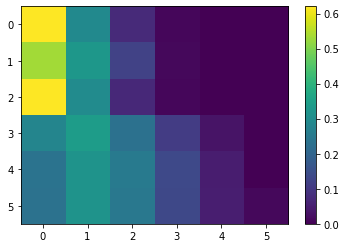

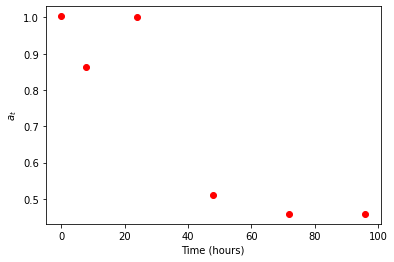

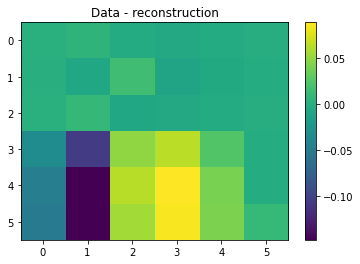

In [85]:
import numpy as np
phos = 'C42H84NO8P'
heavy_p = 'C42H83DNO8P'
# print(Formula(phos).spectrum())
# print(Formula(heavy_p).spectrum())

# will use floored masses 
floor_mz = [760,761,762,763,764,765]
x = []
y = []
phos_s = Formula(phos).spectrum()
heavy_s = Formula(heavy_p).spectrum()
for m in floor_mz:
    x.append(phos_s[m+1][1])
    y.append(heavy_s.get(m+1,(0,0))[1])
# print(x)
# print(y)

n_rows = len(ordered_files)
n_cols = len(x)

data_mat = np.zeros((n_rows,n_cols),np.double)
for i,o in enumerate(ordered_files):
    b,g = all_phosp[o]
    for box in g:
        for j,m in enumerate(floor_mz):
            if int(box.mz) == m:
                data_mat[i,j] = box.height
data_mat /= data_mat.sum(axis=1)[:,None]
plt.imshow(data_mat,aspect='auto')
plt.colorbar()

x = np.array(x)
y = np.array(y)

recon = []

all_a = []
for row in data_mat:
    f = row - y
    m = x-y
    a = ((f*m).sum())/((m*m).sum())
    all_a.append(a)
    recon.append(a*x + (1-a)*y)
    
recon = np.array(recon)
times = [int(x.split(os.sep)[-1].split('_')[0]) for x in ordered_files]
print(times)
plt.figure()
plt.plot(times,all_a,'ro')
plt.xlabel('Time (hours)')
plt.ylabel('$a_t$')

plt.figure()
plt.imshow(data_mat-recon,aspect='auto')
plt.colorbar()
plt.title('Data - reconstruction')

In [40]:

Formula(heavy_p).spectrum()

{762: [762.599732412619, 0.6160190274810488],
 763: [763.6031030434093, 0.2898415043763756],
 764: [764.6061457489421, 0.07679549986831057],
 765: [765.6090414737553, 0.014751813596733875],
 766: [766.6118522851225, 0.0022638395330919483],
 767: [767.6146068772607, 0.0002920841230373762],
 768: [768.6173229623139, 3.268094777919464e-05],
 769: [769.6200126860548, 3.236432072089884e-06],
 770: [770.6227375335814, 2.831681532426452e-07],
 771: [771.6257860585823, 1.573936287709506e-08],
 772: [772.6290915923876, 1.4079510976923437e-10]}